README:
This model iteration contains the code for the following hyperparameters/metrics:



In [4]:
# this box just gets the metadata of the data we are downloading, 100 each for an initial test
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import shutil
from tqdm import tqdm
import kagglehub

path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

# 1. Load metadata
metadata_path = os.path.join(path, "HAM10000_metadata.csv")
metadata = pd.read_csv(metadata_path)

# 2. Filter to the 3 target classes
target_classes = ['bkl', 'bcc', 'nv']
filtered_metadata = metadata[metadata['dx'].isin(target_classes)]

# 3. Limit each class to 100 images by sampling lesions
limits = {'nv': 6705, 'bkl': 1099, 'bcc': 514}
selected_metadata = []

for dx in limits:
    class_df = filtered_metadata[filtered_metadata['dx'] == dx]
    lesion_ids = class_df['lesion_id'].drop_duplicates().sample(frac=1, random_state=42)

    selected_lesions = []
    selected_count = 0

    for lesion in lesion_ids:
        lesion_imgs = class_df[class_df['lesion_id'] == lesion]
        if selected_count + len(lesion_imgs) > limits[dx]:
            continue
        selected_lesions.append(lesion)
        selected_count += len(lesion_imgs)
        if selected_count >= limits[dx]:
            break

    subset = class_df[class_df['lesion_id'].isin(selected_lesions)]
    selected_metadata.append(subset)

limited_metadata = pd.concat(selected_metadata).reset_index(drop=True)

print("Limited class distribution:\n", limited_metadata['dx'].value_counts())


Limited class distribution:
 dx
nv     6705
bkl    1099
bcc     514
Name: count, dtype: int64


In [5]:
# This coding block sets up the training data and validation data to make it model ready

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

# target size for images, in this case images already preprocessed from dataset 600X450
IMG_SIZE = (600, 450)

# set number of images per training/test batch
BATCH_SIZE = 8
DATA_DIR = "/content/drive/MyDrive/BME450/Group Project/3classes_n=all_dataset"

# set up the training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels = "inferred",
    label_mode = "categorical",
    shuffle = True # shuffle the training data
)

# set up the validation data, same parameters as training
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels = "inferred",
    label_mode = "categorical",
    shuffle = False # do not shuffle the validation data
)

# Save class names for later use
class_names = val_ds.class_names

# Import preprocessing function
from tensorflow.keras.applications.resnet50 import preprocess_input

# Setup for optimized pipeline
AUTOTUNE = tf.data.AUTOTUNE

# Preprocess → then cache + prefetch
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)

# removed caching
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 6529 files belonging to 3 classes.
Found 1661 files belonging to 3 classes.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
class_names

['bcc', 'bkl', 'nv']

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

num_classes = 3

# load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1],3))
base_model.trainable = False # only train the Dense layer first

# custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

outputs = Dense(num_classes, activation = 'softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'AUC', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 600, 450,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 606, 456,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 300, 225,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 300, 225,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 300, 225,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 302, 227,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 150, 113,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 150, 113,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 150, 113,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 150, 113,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 150, 113,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 150, 113,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 150, 113,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 150, 113,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 150, 113,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 150, 113,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 150, 113,  │      1,024 │ conv2_block1_3_c

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

# **Train the Top Classifier**

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',      # monitor validation loss
    patience=5,              # stop after 5 epochs with no improvement
    restore_best_weights=True # revert to best weights after stopping
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stopping])

Epoch 1/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 787s 938ms/step - AUC: 0.9095 - accuracy: 0.7826 - loss: 0.6594 - precision: 0.7970 - recall: 0.7653 - val_AUC: 0.9721 - val_accuracy: 0.8760 - val_loss: 0.3226 - val_precision: 0.8872 - val_recall: 0.8567
Epoch 2/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 150s 183ms/step - AUC: 0.9679 - accuracy: 0.8627 - loss: 0.3493 - precision: 0.8772 - recall: 0.8492 - val_AUC: 0.9775 - val_accuracy: 0.8904 - val_loss: 0.2850 - val_precision: 0.9025 - val_recall: 0.8754
Epoch 3/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 198s 179ms/step - AUC: 0.9712 - accuracy: 0.8662 - loss: 0.3304 - precision: 0.8807 - recall: 0.8557 - val_AUC: 0.9782 - val_accuracy: 0.8940 - val_loss: 0.2778 - val_precision: 0.9027 - val_recall: 0.8826
Epoch 4/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 145s 177ms/step - AUC: 0.9746 - accuracy: 0.8788 - loss: 0.3098 - precision: 0.8894 - recall: 0.8688 - val_AUC: 0.9790 - val_accuracy: 0.8898 - val_loss: 0.2773 - val_precision: 0.9054 - val_recall: 0.8820
Epoch 5/50
817/8

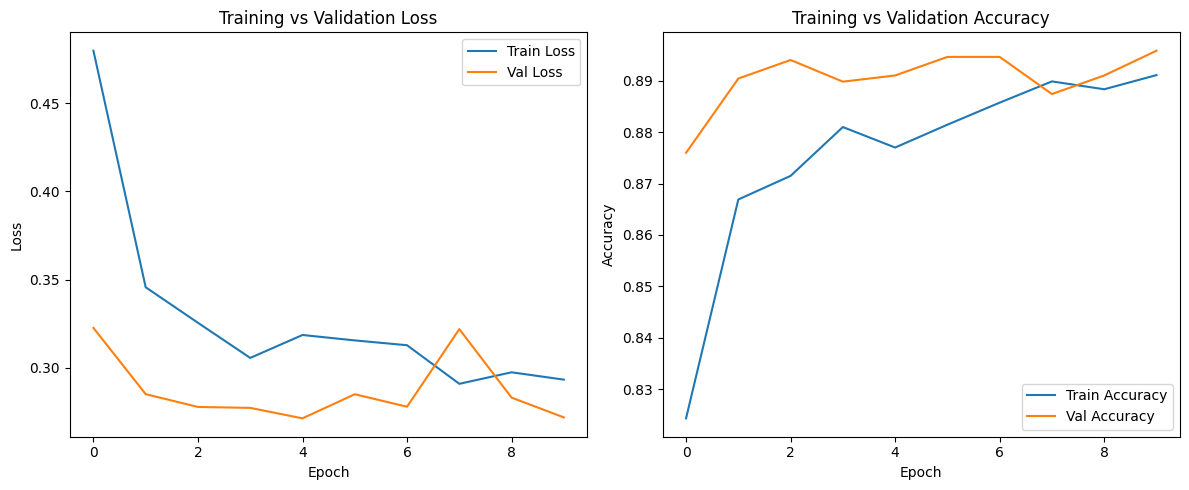

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Get model predictions (probabilities)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = np.concatenate([y for _, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

208/208 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step


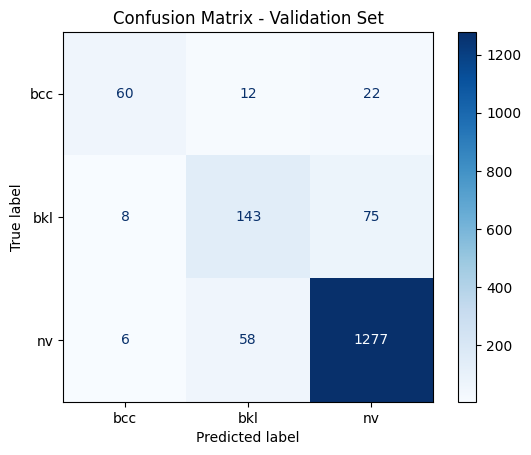

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#class_names = val_ds.class_names  # Gets class labels in correct order
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()

# **Fine Tune the Model**

In [ ]:
# help the model generalize by unfreezing layers and retraining with a smaller learning rate
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

In [ ]:
history2 = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stopping])

Epoch 1/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 145s 177ms/step - AUC: 0.9760 - accuracy: 0.8856 - loss: 0.3020 - precision: 0.8925 - recall: 0.8743 - val_AUC: 0.9778 - val_accuracy: 0.8964 - val_loss: 0.2910 - val_precision: 0.9073 - val_recall: 0.8838
Epoch 2/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 157s 192ms/step - AUC: 0.9723 - accuracy: 0.8748 - loss: 0.3296 - precision: 0.8830 - recall: 0.8653 - val_AUC: 0.9755 - val_accuracy: 0.8946 - val_loss: 0.3119 - val_precision: 0.9025 - val_recall: 0.8856
Epoch 3/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 206s 196ms/step - AUC: 0.9774 - accuracy: 0.8882 - loss: 0.2916 - precision: 0.8961 - recall: 0.8796 - val_AUC: 0.9745 - val_accuracy: 0.8868 - val_loss: 0.3272 - val_precision: 0.8926 - val_recall: 0.8802
Epoch 4/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 158s 194ms/step - AUC: 0.9767 - accuracy: 0.8859 - loss: 0.2989 - precision: 0.8931 - recall: 0.8790 - val_AUC: 0.9796 - val_accuracy: 0.8940 - val_loss: 0.2787 - val_precision: 0.9014 - val_recall: 0.8862
Epoch 5/50
817/8

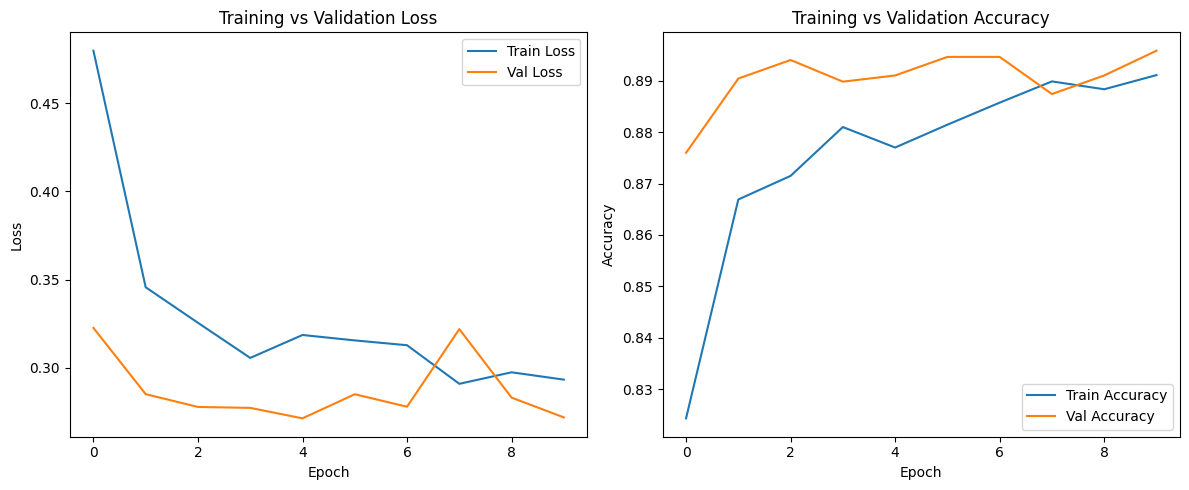

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Get model predictions (probabilities)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = np.concatenate([y for _, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#class_names = val_ds.class_names  # Gets class labels in correct order
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()